# Imports

In [1]:
import os
import pickle
import random
import pathlib
import unicodedata

In [2]:
from itertools import groupby
from operator import itemgetter

In [3]:
import nltk
import numpy as np

# Constants

In [4]:
PROJECT_DIR = pathlib.Path('~/project').expanduser()
DATA_DIR = PROJECT_DIR / 'data'
CORPUS_ROOT = DATA_DIR / 'sample'

# PickledCorpusReader

In [5]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

In [6]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for sent in self.sents(fileids, categories):
            for token, tag in sent:
                yield token, tag

In [7]:
from collections import Counter

corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
words  = Counter(corpus.words())

print(f"{len(words.keys()):,} vocabulary {sum(words.values()):,} word count")

77,930 vocabulary 1,624,862 word count


In [8]:
for category in corpus.categories():

    n_docs = len(corpus.fileids(categories=[category]))
    n_words = sum(1 for word in corpus.words(categories=[category]))

    print("- '{}' contains {:,} docs and {:,} words".format(category, n_docs, n_words))

- 'books' contains 71 docs and 41,438 words
- 'business' contains 389 docs and 222,182 words
- 'cinema' contains 100 docs and 69,153 words
- 'cooking' contains 30 docs and 37,854 words
- 'data_science' contains 41 docs and 31,354 words
- 'design' contains 55 docs and 18,260 words
- 'do_it_yourself' contains 122 docs and 28,050 words
- 'gaming' contains 128 docs and 70,778 words
- 'news' contains 1,159 docs and 850,688 words
- 'politics' contains 149 docs and 88,853 words
- 'sports' contains 118 docs and 68,884 words
- 'tech' contains 176 docs and 97,368 words


# Unsupervised Learning on Text

# Clustering by Document Similarity

## Distance Metrics

## Partitive Clustering

### k-means clustering

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english', join=False):
        self.language = language
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()
        self.join = join

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token)
            and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        if self.join:
            return [self.normalize(doc) for doc in documents]
        else:
            return [' '.join(self.normalize(doc)) for doc in documents]

In [11]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    """Transforms sparse to dense"""

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray()

In [12]:
class ListTransformer(BaseEstimator, TransformerMixin):
    """Transforms 2D array to list of 1D arrays"""

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return list(X)

In [ ]:
from nltk.cluster import KMeansClusterer

class KMeansClusters(BaseEstimator):
    """sklearn wrapper for nltk.cluster.KMeansClusterer"""
    
    def __init__(self, k, distance, random_state=None):
        """
        k is the number of clusters
        model is the implementation of Kmeans
        """
        self.k = k
        self.distance = distance
        self.random_state = random_state
        self.model = KMeansClusterer(num_means=self.k,
                                     distance=self.distance,
                                     rng=random.Random(self.random_state),
                                     avoid_empty_clusters=True)
        
    def fit(self, documents, labels=None):
        """
        Fits the K-Means model to one-hot vectorized documents.
        """
        self.model.cluster(documents)
        return self
    
    def predict(self, documents):
        """
        Predicts the closest cluster for each document in documents.
        """
        return list(map(self.model.classify, documents))
    
    def fit_predict(self, documents, labels=None):
        """Calls fit() and predict() methods"""
        return self.fit(documents).predict(documents)

In [ ]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    ('list_transformer', ListTransformer()),
    ('clusters', KMeansClusters(k=7,
                                distance=nltk.cluster.util.cosine_distance,
                                random_state=42)),
])

In [ ]:
documents = corpus.docs(categories=['news'])

In [ ]:
%%time
%%capture
clusters = pipeline.fit_predict(documents)

In [ ]:
# Classify documents in the new corpus by cluster affinity
fileids = corpus.fileids(categories=['news'])
clusters = pipeline.predict(corpus.docs(fileids=fileids))
groups = list(zip(clusters, fileids))

In [ ]:
# Group documents in corpus by cluster and display them
groups.sort(key=itemgetter(0))
for group, items in groupby(groups, key=itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

### Optimizing k-means

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('clusters', MiniBatchKMeans(n_clusters=7,
                                 random_state=42)),
])

In [ ]:
documents = corpus.docs(categories=['news'])

In [ ]:
%%time
%%capture
clusters = pipeline.fit_predict(documents)

In [ ]:
# Classify documents in the new corpus by cluster affinity
fileids = corpus.fileids(categories=['news'])
clusters = pipeline.predict(corpus.docs(fileids=fileids))
groups = list(zip(clusters, fileids))

In [ ]:
# Group documents in corpus by cluster and display them
groups.sort(key=itemgetter(0))
for group, items in groupby(groups, key=itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

### Handling uneven geometries

## Hierarchical Clustering

### Agglomerative clustering I

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    ('clusters', AgglomerativeClustering()),
])

In [ ]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [28]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 8.23 s, sys: 151 ms, total: 8.38 s
Wall time: 9.32 s


In [29]:
clusters = pipeline['clusters'].labels_
groups = list(zip(clusters, fileids))

In [30]:
# Group documents in corpus by cluster and display them
groups.sort(key=itemgetter(0))
for group, items in groupby(groups, key=itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

Cluster 1: news/56d6255dc1808113ffb874f0.pickle
Cluster 2: news/56d62554c1808113ffb87492.pickle


In [31]:
documents = corpus.docs(fileids=fileids)

In [32]:
from collections import Counter

labels = [
    [item for item, count in Counter(document.split(' ')).most_common(10)]
    for document in pipeline['normalizer'].transform(documents)
]

In [33]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Distances between each pair of children
    distance = position = np.arange(len(model.children_))
    
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack((
       model.children_, distance, position
    )).astype('float')
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.tick_params(axis='x', bottom='off', top='off', labelbottom='off')
    plt.tight_layout()

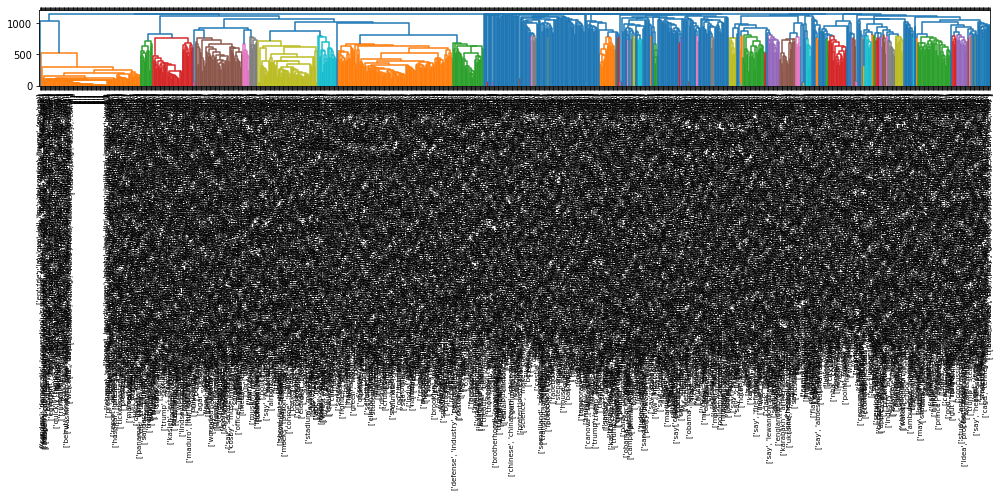

In [34]:
plt.figure(figsize=(14, 7))
plot_dendrogram(model=pipeline['clusters'], 
                labels=labels, 
                leaf_font_size=7)
plt.show()

### Agglomerative clustering II

In [35]:
from sklearn.cluster import AgglomerativeClustering

In [36]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    # setting distance_threshold=0 ensures we compute the full tree
    ('clusters', AgglomerativeClustering(distance_threshold=0,
                                         n_clusters=None)),
])

In [37]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [38]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 8.51 s, sys: 186 ms, total: 8.7 s
Wall time: 9.67 s


In [39]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(len(model.children_))
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.tight_layout()

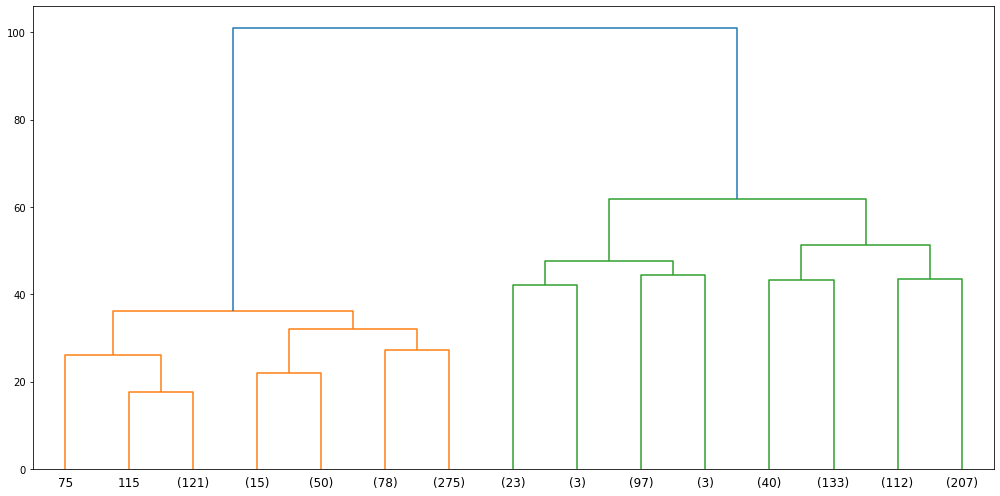

In [40]:
plt.figure(figsize=(14, 7))
plot_dendrogram(model=pipeline['clusters'], 
                truncate_mode="level", p=3)
plt.show()

# Modeling Document Topics

## Latent Dirichlet Allocation

### In Scikit-Learn

In [41]:
from sklearn.decomposition import LatentDirichletAllocation

In [42]:
pipeline = Pipeline([
    ('features', Pipeline([
        ('normalizer', TextNormalizer()),
        ('vectorizer', CountVectorizer(lowercase=False)),
    ])),
    ('model', LatentDirichletAllocation(n_components=50,
                                        n_jobs=-1,
                                        random_state=42)),
])

In [43]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [44]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 3.24 s, sys: 1.26 s, total: 4.49 s
Wall time: 9.53 s


#### Get topics

In [45]:
def get_topics(pipeline, n=25):
    """
    n is the number of top terms to show for each topic
    """
    components = pipeline['model'].components_
    feature_names = (pipeline['features']['vectorizer']
                     .get_feature_names())
    return {topic_idx: [feature_names[i] for i in
                        topic.argsort()[-1:-(n + 1):-1]]
            for topic_idx, topic in enumerate(components)}

In [46]:
topics = get_topics(pipeline)

In [47]:
for topic, terms in topics.items():
    print(f'Topic #{topic}:')
    print(terms)

Topic #0:
['kava', 'hawi', 'hawaii', 'beach', 'say', 'com', 'use', 'suicide', 'www', 'electric', 'include', 'park', 'patient', 'new', 'antidepressant', 'condition', 'canada', 'doctor', 'island', 'assist', 'assisted', 'gibson', 'hotel', 'study', 'salad']
Topic #1:
['say', 'would', 'new', 'make', 'one', 'get', 'year', 'also', 'rule', 'statement', 'last', 'take', 'fight', 'abortion', 'time', 'tell', 'overtime', 'go', 'state', 'police', 'day', 'bill', 'see', 'people', 'law']
Topic #2:
['bergdahl', 'say', 'prison', 'koenig', 'year', 'would', 'case', 'one', 'episode', 'time', 'court', 'also', 'tell', 'sentence', 'take', 'soldier', 'know', 'two', 'family', 'guzmán', 'hastert', 'go', 'could', 'day', 'home']
Topic #3:
['get', 'go', 'like', 'make', 'stepanov', 'use', 'two', 'time', 'transit', 'keteyian', 'armen', 'eat', 'russia', 'take', 'vitaly', 'year', 'anti', 'mercury', 'pension', 'food', 'dope', 'say', 'also', 'would', 'ftc']
Topic #4:
['mr', 'house', 'say', 'president', 'party', 'year', 'o

#### Get top topic

In [48]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [49]:
%%time
pipeline.transform(documents).argmax(axis=1)

CPU times: user 1.95 s, sys: 199 ms, total: 2.14 s
Wall time: 3.45 s


array([ 2, 24, 22, ...,  0, 28,  0])

#### Visualize topics

In [90]:
import pyLDAvis
import pyLDAvis.sklearn as sklearnvis

### The Gensim way

In [50]:
import gensim

In [51]:
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

In [52]:
from gensim.sklearn_api import ldamodel

In [53]:
class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, dirpath=".", tofull=False):
        """
        Pass in a directory that holds the lexicon in corpus.dict and the
        TFIDF model in tfidf.model (for now).

        Set tofull = True if the next thing is a Scikit-Learn estimator
        otherwise keep False if the next thing is a Gensim model.
        """
        self.dirpath = dirpath
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")

        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull

        self.load()

    def load(self):

        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)

        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel().load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel(corpus=[self.lexicon.doc2bow(doc)
                                        for doc in documents],
                                id2word=self.lexicon)
        self.save()
        return self

    def transform(self, documents):
        def generator():
            for document in documents:
                vec = self.tfidf[self.lexicon.doc2bow(document)]
                if self.tofull:
                    yield sparse2full(vec)
                else:
                    yield vec
        return list(generator())

In [54]:
pipeline = Pipeline([
    ('features', Pipeline([
        ('normalizer', TextNormalizer(join=True)),
        ('vectorizer', GensimTfidfVectorizer()),
    ])),
    ('model', ldamodel.LdaTransformer(num_topics=50,
                                      random_state=42)),
])

In [55]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

#### Get topics

In [56]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 43.9 s, sys: 261 ms, total: 44.2 s
Wall time: 9.48 s


In [57]:
pipeline['model'].gensim_model.show_topics(num_topics=-1)

[(0,
  '0.001*"1097" + 0.001*"4024" + 0.001*"26760" + 0.001*"19645" + 0.001*"2705" + 0.001*"16112" + 0.001*"6408" + 0.001*"3096" + 0.001*"158" + 0.001*"11342"'),
 (1,
  '0.002*"1097" + 0.001*"16085" + 0.001*"16749" + 0.001*"240" + 0.001*"1625" + 0.001*"223" + 0.001*"1485" + 0.001*"20403" + 0.001*"6889" + 0.001*"470"'),
 (2,
  '0.001*"18935" + 0.001*"1097" + 0.001*"11992" + 0.001*"5981" + 0.001*"24634" + 0.001*"4961" + 0.001*"5951" + 0.001*"1483" + 0.001*"24844" + 0.001*"1118"'),
 (3,
  '0.001*"1097" + 0.001*"20879" + 0.001*"20500" + 0.001*"990" + 0.001*"21505" + 0.001*"915" + 0.001*"22024" + 0.001*"22077" + 0.001*"7040" + 0.001*"3094"'),
 (4,
  '0.001*"1090" + 0.001*"10803" + 0.001*"26041" + 0.001*"915" + 0.001*"18954" + 0.001*"1097" + 0.001*"7545" + 0.001*"15538" + 0.001*"12300" + 0.001*"2873"'),
 (5,
  '0.001*"1020" + 0.001*"13290" + 0.001*"12786" + 0.001*"17424" + 0.001*"18279" + 0.001*"19570" + 0.001*"18321" + 0.001*"11961" + 0.001*"6362" + 0.001*"1999"'),
 (6,
  '0.001*"22753" + 0

#### Get top topic

In [58]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [59]:
%%time
pipeline.transform(documents).argmax(axis=1)

CPU times: user 9.47 s, sys: 163 ms, total: 9.63 s
Wall time: 4.48 s


array([16, 49, 14, ...,  0,  3, 43])

#### Visualize topics

In [85]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [86]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [87]:
model = pipeline['model'].gensim_model
features = pipeline['features'].transform(documents)
lexicon = pipeline['features']['vectorizer'].lexicon

In [88]:
%%time
%%capture
data = gensimvis.prepare(model, features, lexicon)

CPU times: user 5.12 s, sys: 68.8 ms, total: 5.19 s
Wall time: 3.26 s


In [ ]:
pyLDAvis.display(data)

## Latent Semantic Analysis

### In Scikit-Learn

### The Gensim way

## Non-Negative Matrix Factorization

### In Scikit-Learn